In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


# **YOUR <font color='red'>SECOND</font> RECSYS**



<div>
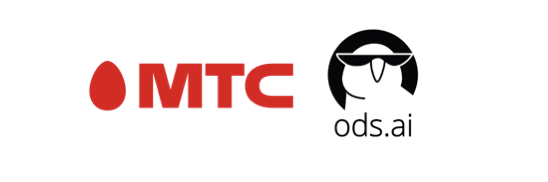
</div>


# Intro

Всем привет!
В этой лекции мы разберемся как обучить простую DSSM-нейронку на данных KION, а еще поскорим ее в оффлайне. Погнали!

In [ ]:
import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from random import randint, random
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from tensorflow import keras
from tqdm import tqdm

Загрузим данные Киона

In [ ]:
users_df = pd.read_csv("/gdrive/MyDrive/work/mts/data_kion/users.csv")
items_df = pd.read_csv("/gdrive/MyDrive/work/mts/data_kion/items.csv")
interactions_df = pd.read_csv("/gdrive/MyDrive/work/mts/data_kion/interactions.csv")

# Подготовка данных

## EDA

Для начала посмотрим на данные:

In [ ]:
users_df.head()

,user_id,age,income,sex,kids_flg,business_dt
0,973171,age_25_34,income_60_90,М,1,2021-09-10
1,962099,age_18_24,income_20_40,М,0,2021-09-10
2,1047345,age_45_54,income_40_60,Ж,0,2021-09-10
3,721985,age_45_54,income_20_40,Ж,0,2021-09-10
4,704055,age_35_44,income_60_90,Ж,0,2021-09-10


In [ ]:
items_df.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,keywords,description,business_dt
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...","Поговори, ней, 2002, Испания, друзья, любовь, ...",Мелодрама легендарного Педро Альмодовара «Пого...,2021-09-10
1,8250,film,Объезд,Detour,2013.0,"зарубежные, триллеры",США,NaN,16.0,NaN,Уильям Дикерсон,"Бриа Грант, Джон Форест, Дэб Снайдер, Нил Хопк...","Объезд, 2013, США, выживание, диких, условиях,...","История среднестатистического американца, чью ...",2021-09-10
2,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...","Голые, перцы, 2014, США, друзья, свадьбы, прео...",Уморительная современная комедия на популярную...,2021-09-10
3,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...","Тактическая, сила, 2011, Канада, бандиты, ганг...",Профессиональный рестлер Стив Остин («Все или ...,2021-09-10
4,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","45, лет, 2015, Великобритания, брак, жизнь, лю...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...",2021-09-10


In [ ]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


## Готовим фичи пользователей

Посмотрим, какие фичи в датасете фильмов являются категориальными и закодируем их с помощью one-hot encoding.

In [ ]:
user_cat_feats = ["age", "income", "sex", "kids_flg"]

# из исходного датафрейма оставим только item_id - этот признак нам понадобится позже
# для того, чтобы маппить айтемы из датафрейма с фильмами с айтемами 
# из датафрейма с взаимодействиями
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
  # получаем датафрейм с one-hot encoding для каждой категориальной фичи
  ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
  # конкатенируем ohe-hot датафрейм с датафреймом, 
  # который мы получили на предыдущем шаге
  users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()


,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,sex_Ж,sex_М,kids_flg_0,kids_flg_1
0,973171,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,962099,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,1047345,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
3,721985,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
4,704055,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0


## Готовим фичи айтемов

Кодируем их точно так же - one-hot'ом.

In [ ]:
item_cat_feats = ['content_type', 'release_year',
                  'for_kids', 'age_rating', 
                  'studios', 'countries', 'directors']

items_ohe_df = items_df.item_id

for feat in item_cat_feats:
  ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
  items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

items_ohe_df.head()

,item_id,content_type_film,content_type_series,release_year_1897.0,release_year_1916.0,release_year_1917.0,release_year_1918.0,release_year_1920.0,release_year_1921.0,release_year_1922.0,release_year_1924.0,release_year_1925.0,release_year_1926.0,release_year_1927.0,release_year_1928.0,release_year_1929.0,release_year_1930.0,release_year_1931.0,release_year_1932.0,release_year_1933.0,release_year_1934.0,release_year_1935.0,release_year_1936.0,release_year_1937.0,release_year_1938.0,release_year_1939.0,release_year_1940.0,release_year_1941.0,release_year_1942.0,release_year_1943.0,release_year_1944.0,release_year_1945.0,release_year_1946.0,release_year_1947.0,release_year_1948.0,release_year_1949.0,release_year_1950.0,release_year_1951.0,release_year_1952.0,release_year_1953.0,...,"directors_Якоб Вербрюгген, Тим Милантс",directors_Яков Базелян,directors_Яков Протазанов,directors_Яков Сегель,directors_Яков Уринов,directors_Якуб Кронер,directors_Ялмари Хеландер,directors_Ям Ларанас,directors_Ян Гэ,directors_Ян Деманж,directors_Ян Комаса,directors_Ян Кунен,directors_Ян Лануетт Тургеон,directors_Ян Ларин,"directors_Ян Лахойер, Джейкоб Шух",directors_Ян Леноре,directors_Ян Самюэль,directors_Ян Ситта,directors_Ян Сысоев,directors_Ян Фрид,directors_Ян Элен,directors_Ян де Бонт,directors_Яна Гладких,directors_Яна Друзь,directors_Яна Ерлашова,"directors_Яна Поляруш, Тамара Цоцория, Константин Кутуев",directors_Яна Титова,directors_Янгджун Л,directors_Яне Магнуссон,"directors_Янн Артюс-Бертран, Анастасия Микова",directors_Яннике Систад Якобсен,directors_Янус Мец,directors_Ярив Хоровиц,directors_Ярон Зильберман,directors_Ярополк Лапшин,directors_Ярослав Лупий,"directors_Ярроу Чейни, Скотт Моужер",directors_Ясина Сезар,directors_Ясуоми Умэцу,directors_сения Завьялова
0,10711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8250,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2508,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10716,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7868,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Собираем матрицу взаимодействий



In [ ]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


В датасете взаимодействий есть непопулярные фильмы и малоактивные пользователи. Кроме того, в таблице взаимодействий есть события с низким качеством взаимодействия - когда юзер начал смотреть фильм, но вскоре после начала просмотра выключил. 

Отфильтруем такие события*, малоактивных юзеров и непопулярные фильмы.

_Можете не фильтровать такие события, тогда у вас будет больше негативных примеров._

In [ ]:
interactions_df.item_id.value_counts()

10440    202457
15297    193123
9728     132865
13865    122119
4151      91167
          ...  
486           1
6290          1
10388         1
14486         1
10218         1
Name: item_id, Length: 15715, dtype: int64

In [ ]:
interactions_df.user_id.value_counts()

416206     1341
1010539     764
555233      685
11526       676
409259      625
           ... 
388806        1
539650        1
194790        1
392900        1
828514        1
Name: user_id, Length: 962198, dtype: int64

In [ ]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

# отфильтруем все события взаимодействий, в которых пользователь посмотрел
# фильм менее чем на 35 процентов
interactions_df = interactions_df[interactions_df.watched_pct > 35]

# соберем всех пользователей, которые посмотрели 
# больше 10 фильмов (можете выбрать другой порог)
valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
  if entries > 10:
    valid_users.append(user_id)

# и соберем все фильмы, которые посмотрели больше 10 пользователей
valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
  if entries > 10:
    valid_items.append(item_id)

# отбросим непопулярные фильмы и неактивных юзеров
interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 962198
N items before: 15715

N users after: 54217
N items after: 6145


После фильтрации может получиться так, что некоторые айтемы/юзеры есть в датасете взаимодействий, но при этом они отсутствуют в датасетах айтемов/юзеров или наоборот. Поэтому найдем id айтемов и id юзеров, которые есть во всех датасетах и оставим только их.

In [ ]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_ohe_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_ohe_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_ohe_df = items_ohe_df[items_ohe_df.item_id.isin(common_items)]
users_ohe_df = users_ohe_df[users_ohe_df.user_id.isin(common_users)]

44963
6141


Соберем взаимодействия в матрицу user*item так, чтобы в строках этой матрицы были user_id, в столбцах - item_id, а на пересечениях строк и столбцов - единица, если пользователь взаимодействовал с айтемом и ноль, если нет.

Такую матрицу удобно собирать в numpy array, однако нужно помнить, что numpy array индексируется порядковыми индексами, а нам же удобнее использовать item_id и user_id.

Создадим некие внутренние индексы для user_id и item_id - uid и iid. Для этого просто соберем все user_id и item_id и пронумеруем их по порядку.

In [ ]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72.0,7234,3504
1,699317,1659,2021-05-29,8317,100.0,28661,594
14,5324,8437,2021-04-18,6598,92.0,208,3087
18,927973,9617,2021-06-19,8422,100.0,37994,3540
20,896751,8081,2021-05-17,6358,100.0,36739,2956


Наконец соберем и отнормируем матрицу взаимодействий:

In [ ]:
interactions_vec = np.zeros((interactions_df.uid.nunique(), 
                             interactions_df.iid.nunique())) 

for user_id, item_id in zip(interactions_df.uid, interactions_df.iid):
    interactions_vec[user_id, item_id] += 1


res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]


In [ ]:
print(interactions_df.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(interactions_df.user_id.nunique())
print(users_ohe_df.user_id.nunique())

set(items_ohe_df.item_id.unique()) - set(interactions_df.item_id.unique())

6141
6141
44963
44963


set()

Для того, чтобы можно было удобно превратить iid/uid в item_id/user_id и наоборот соберем словари 

{iid: item_id}, {uid: user_id} и {item_id: iid}, {user_id: uid}.

In [ ]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

И проиндексируем датасеты users_ohe_df и items_ohe_df по внутренним айди:

In [ ]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe_df = users_ohe_df.set_index("uid")

# DSSM starter's pack

Что нужно для того, чтобы собрать плюс-минус любую нейронку?
- функция потерь
- генератор
- понимание архитектуры модели

Начнем с функции потерь:


## Triplet loss

Triplet loss работает очень просто. Нужно всего лишь...

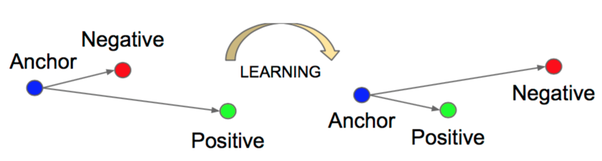

Возьмем вектор юзера (anchor) и векторы двух айтемов - "хорошего" и "плохого" (positive и negative). Хороший айтем - это тот, который пользователь уже посмотрел, а в качестве плохого возьмем любой случайный айтем из датасета. Затем посчитаем расстояния:
1. между вектором юзера и вектором "хорошего" айтема
2. между вектором юзера и вектором "плохого" айтема

_Значением функции потерь будет разность между первым и вторым расстоянием._

In [ ]:
def triplet_loss(y_true, y_pred, n_dims=128, alpha=0.4):
    # будем ожидать, что на вход функции прилетит три сконкатенированных 
    # вектора - вектор юзера и два вектора айтема
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    # считаем расстояния от вектора юзера до вектора хорошего айтема
    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    # и до плохого
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # считаем лосс
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0) # возвращаем ноль, если лосс отрицательный
 
    return loss

*- "а что такое __n_dims__?"*

Это параметр n_dims это размерность внутреннего пространства модели


*- "а что за __alpha__?"*

alpha это гиперпараметр. Если бы его не было, то basic_loss обращался бы в ноль, когда neg_dist = pos_dist и обучения бы на этом примере не происходило. 


*- "как выбрать __alpha__?"*

Как известно, в подборе гиперпараметров нет каких-то железных правил. Но если подумать, то можно установить некоторые зависимости alpha от n_dims и регуляризации в слоях нейронки. Например, чем сильнее регуляризация, тем меньше будут расстояния между векторами, и тем меньше нужно установить alpha. И так же, чем больше внутренняя размерность модели, тем меньше расстояния между векторами. Опять же, получается тем меньше нужно установить alpha.

Если вы хотите больше узнать про триплет лосс - рекомендуем прочитать вот эти две статьи: [[1](https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24)]
и [[2](https://medium.com/@enoshshr/triplet-loss-and-siamese-neural-networks-5d363fdeba9b)]



## Генератор и семплирование

Сделаем простой генератор. Он будет брать рандромного юзера, и два разных айтема - хороший пример и плохой:
- хорошим примером будет тот айтем, который был взят из датасета взаимодействий в соответствии с распределением просмотренных айтемов для этого юзера;
- а плохим айтемом будет просто любой другой _случайный айтем_*


\* _подумайте, как можно использовать информацию о качестве взаимодействия юзеров с айтемами для более репрезентативного сэмплирования?_

In [ ]:
def generator(items, users, interactions, batch_size=1024):
    while True:
        uid_meta = []
        uid_interaction = []
        pos = []
        neg = []
        for _ in range(batch_size):
            # берем рандомный uid
            uid_i = randint(0, interactions.shape[0]-1)
            # id хорошего айтема
            pos_i = np.random.choice(range(interactions.shape[1]), p=interactions[uid_i])
            # id плохого айтема
            neg_i = np.random.choice(range(interactions.shape[1]))
            # фичи юзера
            uid_meta.append(users.iloc[uid_i])
            # вектор айтемов, с которыми юзер взаимодействовал
            uid_interaction.append(interactions_vec[uid_i])
            # фичи хорошего айтема
            pos.append(items.iloc[pos_i])
            # фичи плохого айтема
            neg.append(items.iloc[neg_i])
            
        yield [np.array(uid_meta), np.array(uid_interaction), np.array(pos), np.array(neg)], [np.array(uid_meta), np.array(uid_interaction)]


Посмотрим, что получается:

In [ ]:
# инициализируем генератор
gen = generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                users=users_ohe_df.drop(["user_id"], axis=1), 
                interactions=interactions_vec)

ret = next(gen)


print(f"вектор фичей юзера: {ret[0][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[0][1].shape}")
print(f"вектор 'хорошего' айтема: {ret[0][2].shape}")
print(f"вектор 'плохого' айтема: {ret[0][3].shape}")
print()
print(f"вектор фичей юзера: {ret[1][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[1][1].shape}")

вектор фичей юзера: (1024, 16)
вектор взаимодействий юзера с айтемами: (1024, 6141)
вектор 'хорошего' айтема: (1024, 8829)
вектор 'плохого' айтема: (1024, 8829)

вектор фичей юзера: (1024, 16)
вектор взаимодействий юзера с айтемами: (1024, 6141)


## Собираем модель

Для того, чтобы обучить модель используя триплет лосс, нам нужно получить три вектора - вектор юзера, вектор "хорошего" айтема и вектор "плохого" айтема. Для этого нам нужно две модели ("хороший" и "плохой" айтем будут семплироваться одной и той же моделью).  

Модель юзера будет иметь два входа:
- вход для фичей юзера (фичи из users_ohe_df)
- вход для вектора айтемов, которые посмотрел юзер (строка interactions_vec, которая соответствует uid конкретного юзера)

Выход модели юзера будет размерностью N_FACTORS.

У модели айтема будет один вход для фичей айтема (из items_ohe_df) и один выход также размерностью N_FACTORS.

Общая архитектура будет вот такой: 
- есть модель юзера и модель айтема
- обе модели семплируют юзер и айтем-фичи во внутреннее пространство размерностью N_FACTORS
- модель айтема семплирует два айтема - "хороший" и "плохой"
- в итоге получается три вектора размерностью N_FACTORS (вектор юзера, вектор "хорошего" айтема и вектор "плохого" айтема)
- затем полученные векторы конкатенируются, по ним считается triplet loss
- profit

Для того, чтобы собрать модель, помимо размерности внутреннего пространства, нам нужно знать еще размерность вектора юзера и вектора айтема. Зададим их сразу.

In [ ]:
N_FACTORS = 128

# в датасетах есть столбец user_id/item_id, помним, что он не является фичей для обучения!
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], ) 
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (8829,)
USER_META_MODEL_SHAPE: (16,)
USER_INTERACTION_MODEL_SHAPE: (6141,)


In [ ]:
def item_model(n_factors=N_FACTORS):
    # входной слой
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
    
    # полносвязный слой
    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)

    # делаем residual connection - складываем два слоя, 
    # чтобы градиенты не затухали во время обучения
    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)
    
    add = keras.layers.Add()([layer_1, layer_2])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)
    
    return keras.models.Model(inp, out)


def user_model(n_factors=N_FACTORS):
    # входной слой для вектора фичей юзера (из users_ohe_df)
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    # входной слой для вектора просмотров (из iteractions_vec)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    # полносвязный слой
    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)

    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)

    # делаем residual connection - складываем два слоя,
    # чтобы градиенты не затухали во время обучения
    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)
    

    add = keras.layers.Add()([layer_1_meta, layer_2_meta])
    
    # конкатенируем вектор фичей с вектором просмотров
    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)
    
    return keras.models.Model([inp_meta, inp_interaction], out)

# инициализируем модели юзера и айтема
i2v = item_model()
u2v = user_model()

# вход для вектора фичей юзера (из users_ohe_df)
ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
# вход для вектора просмотра юзера (из interactions_vec)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

# вход для вектора "хорошего" айтема
pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
# вход для вектора "плохого" айтема
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

# получаем вектор юзера
ancor = u2v([ancor_meta_in, ancor_interaction_in])
# получаем вектор "хорошего" айтема
pos = i2v(pos_in)
# получаем вектор "плохого" айтема
neg = i2v(neg_in)

# конкатенируем полученные векторы
res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

# собираем модель
model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

*- а почему не Pytorch?*

> В нашей команде звезды сошлись так, что мы пишем нейронки на TF. Какой-то особенной причины нет, если вы привыкли писать на торче - вэлком! Модель, которая реализована ниже, имеет очень простую архитектуру, и вы с легкостью сможете воспроизвести ее на любом другом фреймворке.



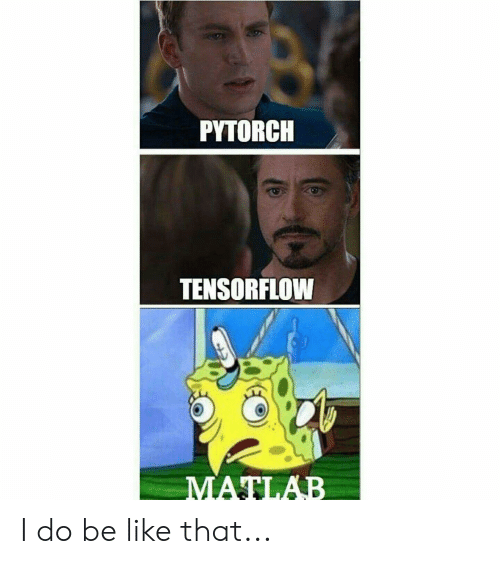

Определяем традиционные коллбэки для обучения.
Коллбэк - это какая-то функция, которая отрабатывает в начале или в конце эпохи.

In [ ]:
model_name = 'recsys_resnet_linear'

# логируем процесс обучения в тензорборд
t_board = keras.callbacks.TensorBoard(log_dir=f'runs/{model_name}')

# уменьшаем learning_rate, если лосс долго не уменьшается (в течение двух эпох)
decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.8, verbose=1)

# сохраняем модель после каждой эпохи, если лосс уменьшился
check = keras.callbacks.ModelCheckpoint(filepath=model_name + '/epoch{epoch}-{loss:.2f}.h5', monitor="loss")


In [ ]:
# компилируем модель, используем оптимайзер Adam и triplet loss
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss=triplet_loss, optimizer=opt)

Посмотрим, что получилось:

In [ ]:
# модель айтема
item_model().summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 8829)]       0                                            
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 128)          1130112     input_37[0][0]                   
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 128)          16384       dense_58[0][0]                   
__________________________________________________________________________________________________
add_17 (Add)                    (None, 128)          0           dense_58[0][0]                   
                                                                 dense_59[0][0]            

In [ ]:
# модель юзера
user_model().summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_61 (Dense)                (None, 128)          2048        input_38[0][0]                   
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 128)          16384       dense_61[0][0]                   
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 6141)]       0                                            
___________________________________________________________________________________________

In [ ]:
# общая модель
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 6141)]       0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 8829)]       0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 8829)]       0                                            
___________________________________________________________________________________________

In [ ]:
# начинаем обучение, не забывая дропнуть столбцы item_id и user_id 
# из датафреймов при инициализации генератора.

# batch_size можно (и лучше) поставить побольше, если вы не органичены в ресурсах

model.fit(generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                    users=users_ohe_df.drop(["user_id"], axis=1), 
                    interactions=interactions_vec,
                    batch_size=64), 
          steps_per_epoch=100, 
          epochs=30, 
          initial_epoch=0,
          callbacks=[decay, t_board, check]
)

# Inference

Отлично! Мы подготовили данные, собрали модель по архитектуре DSSM и обучили ее.
Теперь возьмем случайного юзера и случайный айтем. Как понять, насколько этот айтем релевантен юзеру?

Нужно:
- получить вектор айтема;
- получить вектор юзера;
- посчитать расстояние между ними.

Это расстояние и есть мера релевантности.


In [ ]:
# берем рандомного юзера
rand_uid = np.random.choice(list(users_ohe_df.index))

# получаем фичи юзера и вектор его просмотров айтемов
user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[rand_uid]
user_interaction_vec = interactions_vec[rand_uid]

# берем рандомный айтем
rand_iid = np.random.choice(list(items_ohe_df.index))
# получаем фичи айтема
item_feats = items_ohe_df.drop(["item_id"], axis=1).iloc[rand_iid]

# получаем вектор юзера
user_vec = u2v.predict([np.array(user_meta_feats).reshape(1, -1), 
                        np.array(user_interaction_vec).reshape(1, -1)])

# и вектор айтема
item_vec = i2v.predict(np.array(item_feats).reshape(1, -1))

# считаем расстояние между вектором юзера и вектором айтема
from sklearn.metrics.pairwise import euclidean_distances as ED

ED(user_vec, item_vec)

array([[2.5728612]], dtype=float32)

Окей, получилось примерно два с половиной папугая: 
<div>
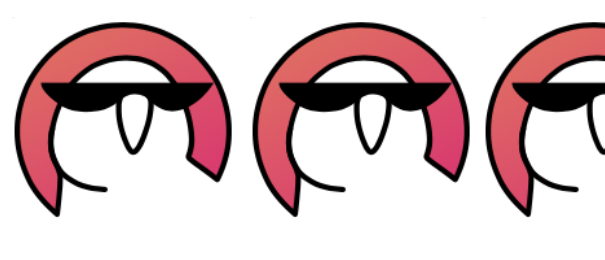
</div>





Что дальше? Как понять, 2.5 это релевантно или нет?
Очень просто: возьмем все айтемы, которые у нас есть, получим векторы для всех из них, а потом посчитаем расстояния от вектора юзера до векторов всех айтемов:

In [ ]:
# получаем фичи всех айтемов
items_feats = items_ohe_df.drop(["item_id"], axis=1).to_numpy()
# получаем векторы всех айтемов
items_vecs = i2v.predict(items_feats)

# считаем расстояния
dists = ED(user_vec, items_vecs)

Теперь мы знаем расстояния от юзера до всех айтемов. Значит, мы легко сможем найти для юзера например топ 5 релевантных айтемов:

In [ ]:
top5_iids = np.argsort(dists, axis=1)[0][:5]
top5_iids

array([3191, 5380, 3267,  828, 4935])

Осталось конвертировать внутренние iid в ~~id здорового человека~~ item_id:

In [ ]:
top5_item_ids = [iid_to_item_id[iid] for iid in top5_iids]
top5_item_ids

[8693, 14500, 8880, 2323, 13337]

In [ ]:
recommended_titles = items_df.loc[items_df.item_id.isin(top5_item_ids)].title
recommended_titles

666      Форсаж: Хоббс и Шоу
2916            Цена страсти
4249                  Бараны
7564                  Глотай
11471    Смертоносная жертва
Name: title, dtype: object

In [ ]:
iids_viewed = np.where(interactions_vec[rand_uid] > 0)
viewed_titles = items_df.iloc[iids_viewed].title
viewed_titles

541                                                 Черта
571                                 Искусство соблазнения
928                                                 Кровь
1008                                     Маленькая смерть
1327                                        Рыцарь кубков
1349                                              Наживка
1629                                   Покажите мне героя
1716                                     Как назло Сибирь
1763                                      Бокс в хиджабах
2100                                               Байкер
2677                                             Чудо-Юдо
2825                             Купание слона. Индонезия
3165                                       Норвежский лес
3577                                             Спасение
3836                                    Берега моей мечты
4182                                     Умный фитнес 2.0
4343                                  Ворон: Ночной шепот
4541          

# Бонус

1. Часто бывает так, что история просмотров айтемов известна далеко не для всех юзеров. Юзеры, которые пока еще никак не взаимодействовали с айтемами, называются холодными. Есть очень простой способ, как эффективно использовать модель, которую мы собрали выше, для таких холодных пользаков.
Для этого нужно переписать генератор так, чтобы он иногда занулял вектор взаимодействий пользователя. В этом случае модель будет использовать только фичи юзера и фичи айтема, что поможет ей работать для холодных пользователей.

2. Также, помимо персональных рекомендаций, можно использовать модель для item to item рекомендаций. Другими словами, можно находить айтемы, которые похожи на конкретный айтем. С помощью нашей модели, это можно сделать, используя модель айтема - похожие друг на друга фильмы будут иметь похожие вектора. Таким образом, если посчитать расстояния от вектора нужного айтема до векторов всех остальных, а потом отранжировать этот список по расстояниям, то можно легко сформировать топ N айтемов похожих на рассматриваемый.

Если у вас остались вопросы, задавайте их здесь!
Telegram: @vsgranovskiy